In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
import xarray as xr
import datetime
import pathlib
import scipy.signal
import subprocess
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
FFT_SIZE = 2**17
FFT_SIZE / 40e3

3.2768

In [3]:
corr_window_size = 200
total_corr = 2 * corr_window_size + 1
doppler_bins = np.arange(-2,3)
f_carrier = 436.4e6
samp_rate = 40e3

In [4]:
def peak_estimator_parabola(x):
    return np.clip(0.5*(x[...,2]-x[...,0])/(2*x[...,1]-x[...,0]-x[...,2]), -0.5, 0.5)

def best_doppler(x):
    return np.argmax(np.max(np.abs(x[..., 1:]), axis = 2), axis = 0)

def corrected_peak(x):
    index = np.real(x[best_doppler(x), np.arange(x.shape[1]).reshape((1,-1)), 0])
    correction = peak_estimator_parabola(np.abs(x[best_doppler(x), np.arange(x.shape[1]).reshape((1,-1)), corr_window_size:corr_window_size+3]))
    return (index + correction).ravel()

def max_corr(x):
    return np.max(np.abs(x[..., 1:]), axis = (0,2))

def prompts(x):
    return x[best_doppler(x), np.arange(x.shape[1]).reshape((1,-1)), corr_window_size+1].ravel()

def compute_phase(x):
    dt = x.coords['time'].diff('time').astype('float')*1e-9
    phase = np.concatenate(([0], np.cumsum(0.5 * (x.values[:-1] + x.values[1:]) * dt)))
    return xr.DataArray(phase, dims = 'time', coords = x.coords)

def accum_phase(x, timestamps, phase0, phase1):
    phi = np.cumsum(doppler_bins[best_doppler(x)]).astype('float64')
    phi += phase0.interp(time = timestamps).values - phase1.interp(time = timestamps).values
    phi *= 2*np.pi
    # here we adjust accumulated phase due to frequency to be referred to the middle of the block
    phi[1:] = 0.5*phi[:-1] + 0.5*phi[1:]
    phi[0] = 0.5*phi[0]
    phi += np.unwrap(np.angle(prompts(x)))
    return phi

def get_accum_phase(x, timestamps, f1, f2):
    p1 = compute_phase(xr.open_dataarray(f1))
    p2 = compute_phase(xr.open_dataarray(f2))
    return accum_phase(x, timestamps, p1, p2)

def get_delta_range(timestamps, f1, f2):
    g1 = xr.open_dataarray(f1)
    g2 = xr.open_dataarray(f2)
    r1 = np.sqrt((g1.sel(object = 'dslwpb_gstopo_x')**2).sum('xyz')) * 1e3
    r2 = np.sqrt((g2.sel(object = 'dslwpb_gstopo_x')**2).sum('xyz')) * 1e3
    return (r1.interp(time = timestamps) - r2.interp(time = timestamps)).values

def hatch_filter(code, phase, alpha = 0.01):
    hatch = np.empty_like(code)
    hatch[0] = code[0]
    for j in range(1, code.size):
        if np.isnan(code[j]) or np.isnan(phase[j]):
            hatch[j] = np.nan
        elif np.isnan(hatch[j-1]):
            # reset filter
            hatch[j] = code[j]
        else:
            # regular iteration
            hatch[j] = alpha*code[j] + (1-alpha)*(phase[j]-phase[j-1]+hatch[j-1])
    return hatch

def kalman_filter(code, phase, snr):
    state_dim = 2
    measure_dim = 2
    
    phase_diff = (phase[2:] - phase[:-2])/2
    phase_diff = np.concatenate(([np.nan], phase_diff, [np.nan]))
    measurements = np.hstack((code.reshape((-1,1)), phase_diff.reshape((-1,1))))
    
    # Kalman matrices
    transition_matrix = np.array([[1,1],[0,1]])
    observation_model = np.array([[1,0],[0,1]])
    process_covariance = np.array([[1e-2,0],[0,1e-2]])
    measurement_covariance_base = np.array([[1e4,0],[0,1e-1]]) * 10**4
    
    # Kalman state variables
    state_priori = np.empty((code.size, state_dim))
    state_posteriori = np.empty_like(state_priori)
    error_covariance_priori = np.empty((code.size, state_dim, state_dim))
    error_covariance_posteriori = np.empty_like(error_covariance_priori)
    innovation = np.empty((code.size, measure_dim))
    innovation_covariance = np.empty((code.size, measure_dim, measure_dim))
    kalman_gain = np.empty((code.size, state_dim, measure_dim))
    post_fit_residual = np.empty_like(innovation)
    
    initial_error_covariance = np.array([[1e4, 0], [0,0.1]])
    
    # initialize filter
    state_priori[0,...] = measurements[0,...]
    state_posteriori[0,...] = measurements[0,...]
    error_covariance_priori[0,...] = initial_error_covariance
    error_covariance_posteriori[0,...] = initial_error_covariance
    innovation[0,...] = np.nan
    innovation_covariance[0,...] = np.nan
    kalman_gain[0,...] = np.nan
    post_fit_residual[0,...] = np.nan    
    
    for j in range(1, code.size):
        if np.any(np.isnan(measurements[j,...])):
            # measurements invalid -> invalidate filter
            state_priori[j,...] = np.nan
            state_posteriori[j,...] = np.nan
            error_covariance_priori[j,...] = np.nan
            error_covariance_posteriori[j,...] = np.nan
            innovation[j,...] = np.nan
            innovation_covariance[j,...] = np.nan
            kalman_gain[j,...] = np.nan
            post_fit_residual[j,...] = np.nan
        elif np.any(np.isnan(state_posteriori[j-1])):
            # state invalid -> reset filter
            state_priori[j,...] = measurements[j,...]
            state_posteriori[j,...] = measurements[j,...]
            error_covariance_priori[j,...] = initial_error_covariance
            error_covariance_posteriori[j,...] = initial_error_covariance
            innovation[j,...] = np.nan
            innovation_covariance[j,...] = np.nan
            kalman_gain[j,...] = np.nan
            post_fit_residual[j,...] = np.nan
        else:
            # predict
            state_priori[j,...] = transition_matrix @ state_posteriori[j-1,...]
            error_covariance_priori[j,...] = \
                transition_matrix @ error_covariance_posteriori[j-1,...] @ transition_matrix.transpose() +\
                process_covariance
            # update
            innovation[j,...] = measurements[j,...] - observation_model @ state_priori[j,...]
            measurement_covariance = measurement_covariance_base * 10**(-snr[j]/10)
            innovation_covariance[j,...] = measurement_covariance +\
                observation_model @ error_covariance_priori[j,...] @ observation_model.transpose()
            # TODO: do not compute inverse
            kalman_gain[j,...] = error_covariance_priori[j,...] @ observation_model.transpose() @ \
                np.linalg.inv(innovation_covariance[j,...])
            state_posteriori[j,...] = state_priori[j,...] + kalman_gain[j,...] @ innovation[j,...]
            error_covariance_posteriori[j,...] = (np.identity(state_dim) - kalman_gain[j,...] @ observation_model) @\
                error_covariance_priori[j,...]
            post_fit_residual[j,...] = measurements[j,...] - observation_model @ state_posteriori[j,...]      
    return state_priori, state_posteriori, error_covariance_priori, error_covariance_posteriori,\
        innovation, innovation_covariance, kalman_gain, post_fit_residual
    

def signal_processing(data, data_path = 'vlbi/outputs/', minimum_corr_dB = -70):
    results = np.load(data_path + data['results'])
    start = np.datetime64(data['start'])
    clk_offset = data['clk_offset']
    
    corr_dB = 20*np.log10(max_corr(results))
    
    time_per_fft = np.timedelta64(int(FFT_SIZE / 40e3 * 1e9), 'ns')
    timestamps = start + np.arange(results.shape[1]) * time_per_fft
     
    accum_phase = get_accum_phase(results, timestamps, data_path + data['doppler1'], data_path + data['doppler2'])
    
    c = 299792458
    deltarange_phase = -accum_phase/(2*np.pi) / f_carrier * c
    deltarange_code = ((corrected_peak(results) - FFT_SIZE//2) / samp_rate  + clk_offset) * c
    
    # correct clock jumps (if any)
    if 'clk_jumps' in data:
        correction = data['clk_jumps'].sel(time = timestamps, method = 'nearest').values * c
        correction_jump = correction[1:] != correction[:-1]
        correction[1:][correction_jump] = np.nan
        correction[:-1][correction_jump] = np.nan
        deltarange_code += correction        
    
    # invalidate measurements with weak correlation
    invalidate = corr_dB < minimum_corr_dB
    deltarange_phase[invalidate] = np.nan
    deltarange_code[invalidate] = np.nan
    
    deltarange_hatch = hatch_filter(deltarange_code, deltarange_phase)
    
    deltarange_kalman = kalman_filter(deltarange_code, deltarange_phase, 100 + corr_dB)[1][:,0]
                                    
    deltarange_gmat = get_delta_range(timestamps, data_path + data['gmat1'], data_path + data['gmat2'])
    
    data = xr.Dataset({'corr_dB' : (['time'], corr_dB),
                       'deltarange_phase' : (['time'], deltarange_phase),
                       'deltarange_code' : (['time'], deltarange_code),
                       'deltarange_hatch' : (['time'], deltarange_hatch),
                       'deltarange_kalman' : (['time'], deltarange_kalman),
                       'deltarange_gmat' : (['time'], deltarange_gmat)},
                      coords = {'time' : timestamps})

    return data

In [5]:
# Generate seconds and items for Dwingeloo (which has clock jumps)

#subprocess.run("gr_read_file_metadata /mnt/disk/dslwp/charon.camras.nl/public/dslwp-b/vlbi/DSLWP-B_PI9CAM_2018-11-21_436MHz.raw | grep Seconds | awk '{print $2;}' > /tmp/dwingeloo_seconds", shell = True)
#subprocess.run("gr_read_file_metadata /mnt/disk/dslwp/charon.camras.nl/public/dslwp-b/vlbi/DSLWP-B_PI9CAM_2018-11-21_436MHz.raw | grep items | awk '{print $1;}' > /tmp/dwingeloo_items", shell = True)
#dwingeloo_seconds = np.fromfile('/tmp/dwingeloo_seconds', sep = ' ')
#np.save('dwingeloo_seconds.npy', dwingeloo_seconds)
#dwingeloo_items = np.fromfile('/tmp/dwingeloo_items', sep = ' ')
#np.save('dwingeloo_items.npy', dwingeloo_items)

In [6]:
dwingeloo_seconds = np.load('dwingeloo_seconds.npy')
dwingeloo_items = np.load('dwingeloo_items.npy')

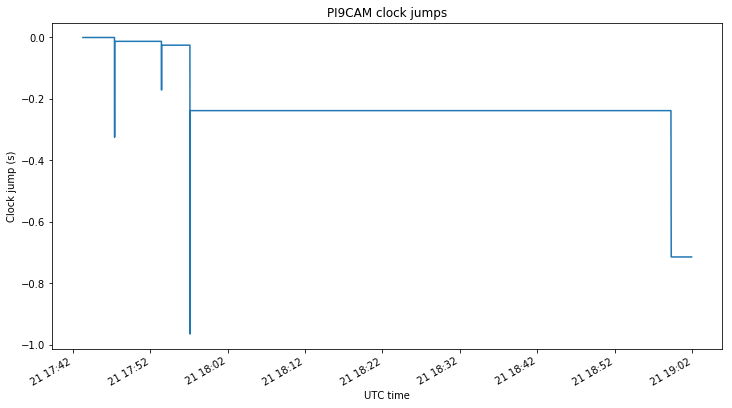

In [7]:
plt.figure(figsize = (12,6), facecolor = 'w')
clock_jumps = np.cumsum(dwingeloo_items / 40e3) - dwingeloo_seconds
clock_jumps -= clock_jumps[0]
clock_timestamps = np.datetime64('1970-01-01') + (dwingeloo_seconds * 1e6) * np.timedelta64(1, 'us')
clock_jumps = xr.DataArray(clock_jumps, coords = [('time', clock_timestamps)])
clock_jumps[:-1].plot()
plt.xlabel('UTC time')
plt.ylabel('Clock jump (s)')
plt.title('PI9CAM clock jumps');

In [8]:
pi9cam_shahe_data = { 'results' : 'results_pi9cam_shahe.npy',
                      'start' : '2018-11-21T17:43:18.224856000',
                      'clk_offset' : -8e-6,
                      'doppler1' : 'doppler_pi9cam_shahe_1.nc',
                      'doppler2' : 'doppler_pi9cam_shahe_2.nc',
                      'gmat1' : 'gmat_pi9cam_shahe_1.nc',
                      'gmat2' : 'gmat_pi9cam_shahe_2.nc',
                      'clk_jumps' : -clock_jumps}

pi9cam_harbin_data = { 'results' : 'results_pi9cam_harbin.npy',
                      'start' : '2018-11-21T17:43:18.224856000',
                      'clk_offset' : -9e-6,
                      'doppler1' : 'doppler_pi9cam_harbin_1.nc',
                      'doppler2' : 'doppler_pi9cam_harbin_2.nc',
                      'gmat1' : 'gmat_pi9cam_harbin_1.nc',
                      'gmat2' : 'gmat_pi9cam_harbin_2.nc',
                      'clk_jumps' : -clock_jumps}

shahe_harbin_data = { 'results' : 'results_shahe_harbin.npy',
                      'start' : '2018-11-21T16:55:00.227889000',
                      'clk_offset' : -1e-6,
                      'doppler1' : 'doppler_shahe_harbin_1.nc',
                      'doppler2' : 'doppler_shahe_harbin_2.nc',
                      'gmat1' : 'gmat_shahe_harbin_1.nc',
                      'gmat2' : 'gmat_shahe_harbin_2.nc'}

In [9]:
pi9cam_shahe = signal_processing(pi9cam_shahe_data)
pi9cam_harbin = signal_processing(pi9cam_harbin_data)
shahe_harbin = signal_processing(shahe_harbin_data)

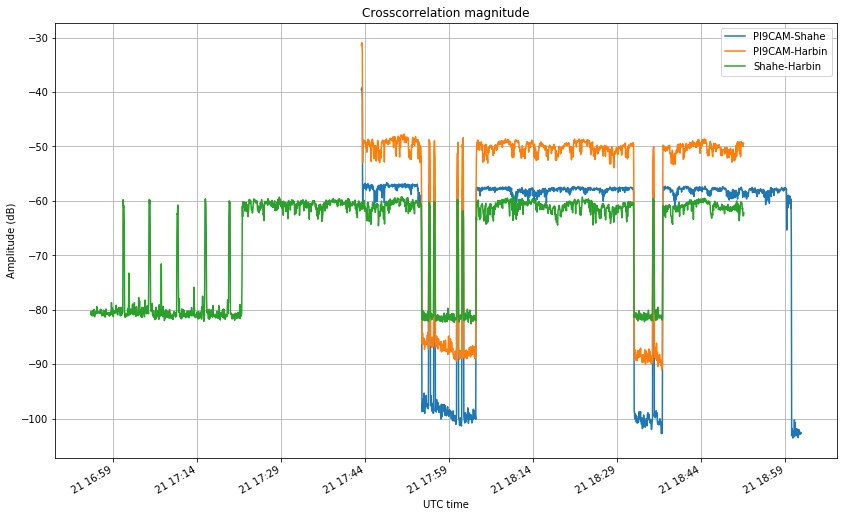

In [10]:
plt.figure(figsize = (14,8), facecolor = 'w')
pi9cam_shahe['corr_dB'].plot()
pi9cam_harbin['corr_dB'].plot()
shahe_harbin['corr_dB'].plot()
plt.legend(['PI9CAM-Shahe', 'PI9CAM-Harbin', 'Shahe-Harbin'])
plt.title('Crosscorrelation magnitude')
plt.ylabel('Amplitude (dB)')
plt.xlabel('UTC time')
plt.grid();

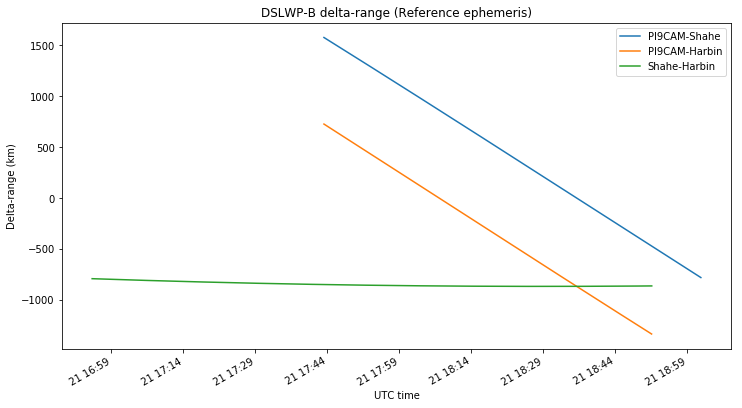

In [11]:
plt.figure(figsize = (12,6), facecolor = 'w')
(1e-3*pi9cam_shahe['deltarange_gmat']).plot()
(1e-3*pi9cam_harbin['deltarange_gmat']).plot()
(1e-3*shahe_harbin['deltarange_gmat']).plot()
plt.title('DSLWP-B delta-range (Reference ephemeris)')
plt.xlabel('UTC time')
plt.ylabel('Delta-range (km)')
plt.legend(['PI9CAM-Shahe', 'PI9CAM-Harbin', 'Shahe-Harbin']);

In [12]:
def plot_deltarange_error(data, station1, station2):
    plt.figure(figsize = (12,6), facecolor = 'w')
    (1e-3*(data['deltarange_code'] - data['deltarange_gmat'])).plot(marker = '.', linestyle='')
    (1e-3*(data['deltarange_hatch'] - data['deltarange_gmat'])).plot()
    (1e-3*(data['deltarange_kalman'] - data['deltarange_gmat'])).plot()
    plt.title(f'DSLWP-B delta-range VLBI between {station1} and {station2} (offset with respect to ephemeris)')
    plt.xlabel('UTC time')
    plt.ylabel('Delta-range offset (km)')
    plt.legend(['Unfiltred', 'Hatch filter', 'Kalman filter'])
    
def plot_deltarange_filtred_error(data, station1, station2, ylim  = None):
    plt.figure(figsize = (12,6), facecolor = 'w')
    (1e-3*(data['deltarange_hatch'] - data['deltarange_gmat'])).plot()
    (1e-3*(data['deltarange_kalman'] - data['deltarange_gmat'])).plot()
    plt.title(f'DSLWP-B delta-range VLBI between {station1} and {station2} (offset with respect to ephemeris)')
    plt.xlabel('UTC time')
    plt.ylabel('Delta-range offset (km)')
    plt.legend(['Hatch filter', 'Kalman filter'])
    if ylim is not None:
        plt.ylim(ylim)

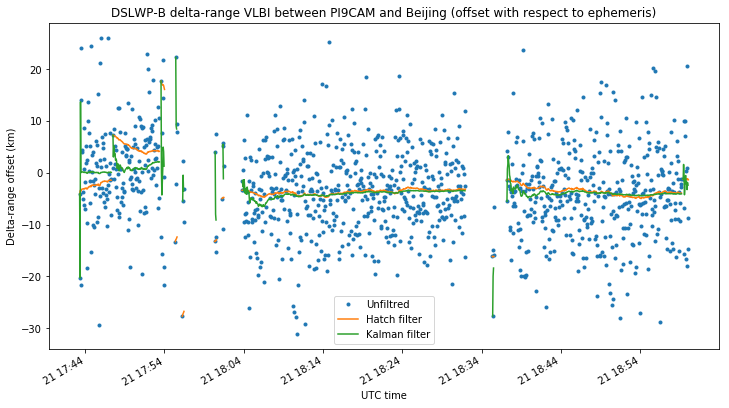

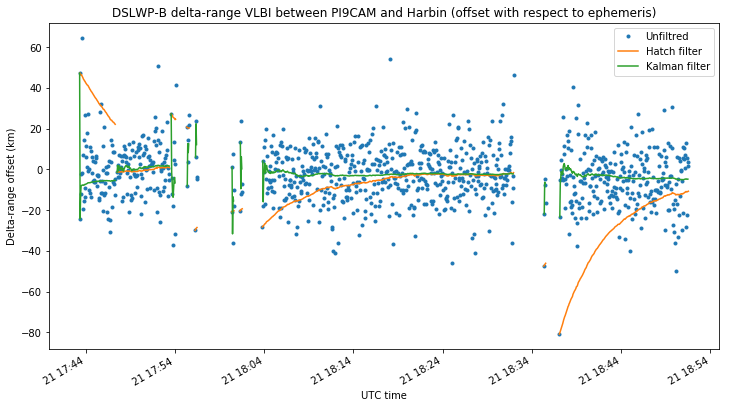

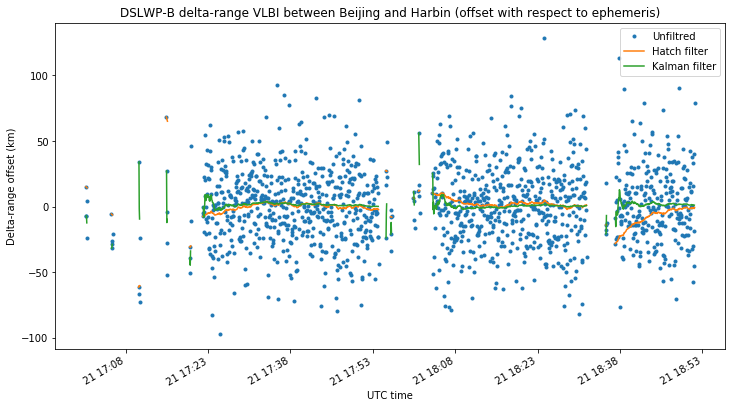

In [13]:
plot_deltarange_error(pi9cam_shahe, 'PI9CAM', 'Beijing')
plot_deltarange_error(pi9cam_harbin, 'PI9CAM', 'Harbin')
plot_deltarange_error(shahe_harbin, 'Beijing', 'Harbin')

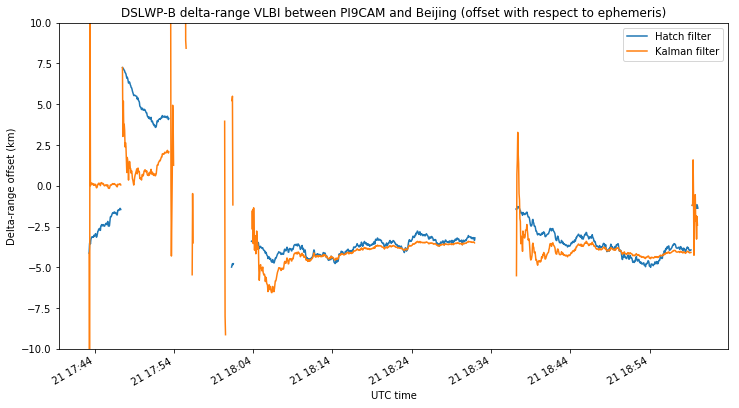

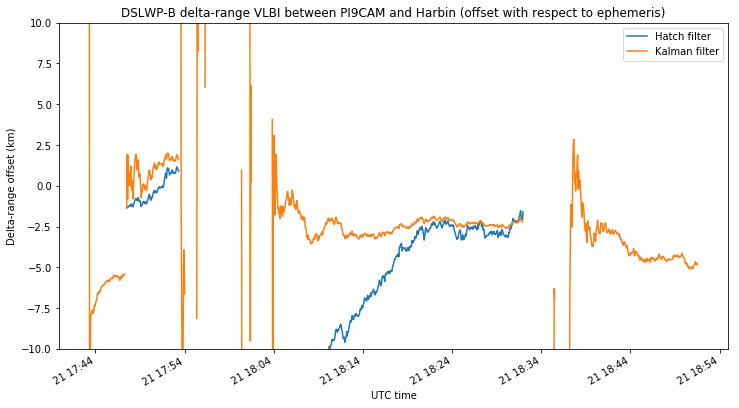

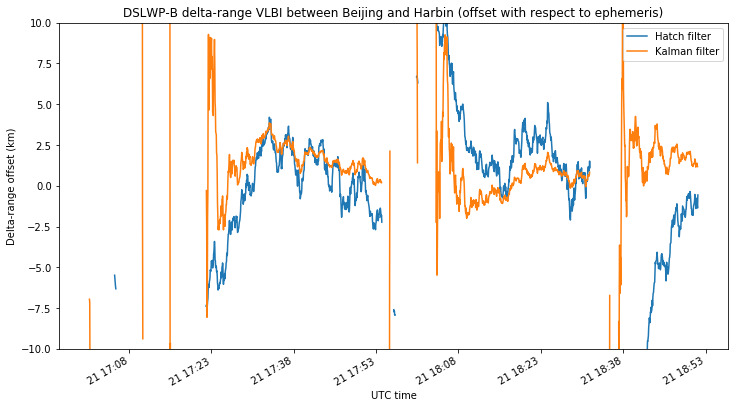

In [14]:
plot_deltarange_filtred_error(pi9cam_shahe, 'PI9CAM', 'Beijing', ylim = (-10,10))
plot_deltarange_filtred_error(pi9cam_harbin, 'PI9CAM', 'Harbin', ylim = (-10,10))
plot_deltarange_filtred_error(shahe_harbin, 'Beijing', 'Harbin', ylim = (-10,10))

In [15]:
def plot_phase_error(data, station1, station2):
    plt.figure(figsize = (12,6), facecolor = 'w')
    phase_error = data['deltarange_phase'][1:] - data['deltarange_gmat'][1:]
    (phase_error-phase_error.mean()).plot()
    plt.title(f'DSLWP-B delta-range VLBI between {station1} and {station2} (phase offset with respect to ephemeris) (average removed)')
    plt.xlabel('UTC time')
    plt.ylabel('Phase offset (m)')

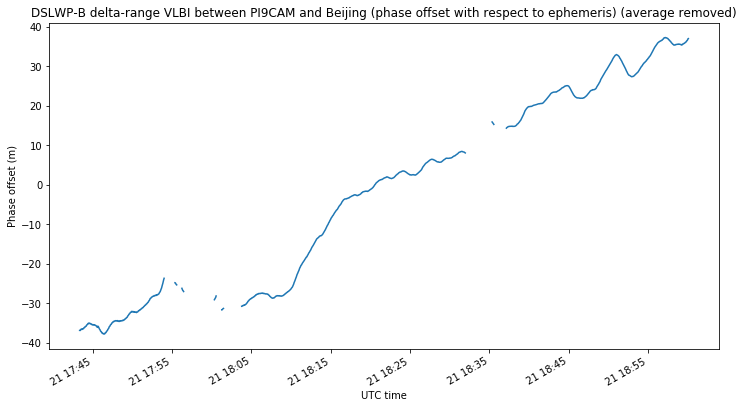

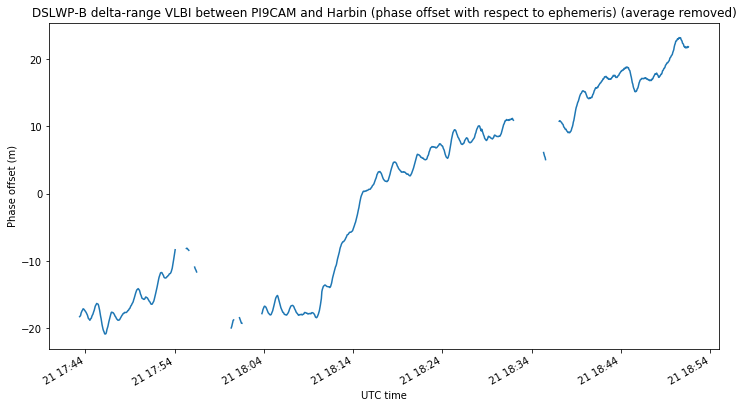

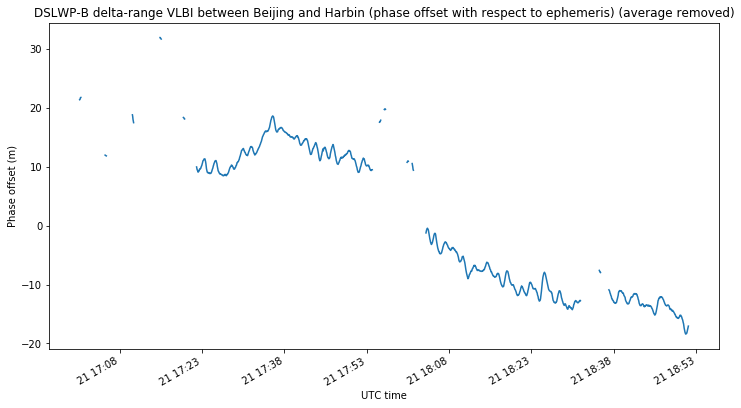

In [16]:
plot_phase_error(pi9cam_shahe, 'PI9CAM', 'Beijing')
plot_phase_error(pi9cam_harbin, 'PI9CAM', 'Harbin')
plot_phase_error(shahe_harbin, 'Beijing', 'Harbin')

In [17]:
def plot_doppler_error(data, station1, station2):
    plt.figure(figsize = (12,6), facecolor = 'w')
    phase_error = data['deltarange_phase'][1:] - data['deltarange_gmat'][1:]
    (phase_error-phase_error.mean()).differentiate('time', datetime_unit='s').plot()
    plt.title(f'DSLWP-B delta-velocity VLBI between {station1} and {station2} (offset with respect to ephemeris)')
    plt.xlabel('UTC time')
    plt.ylabel('Phase offset (m)')

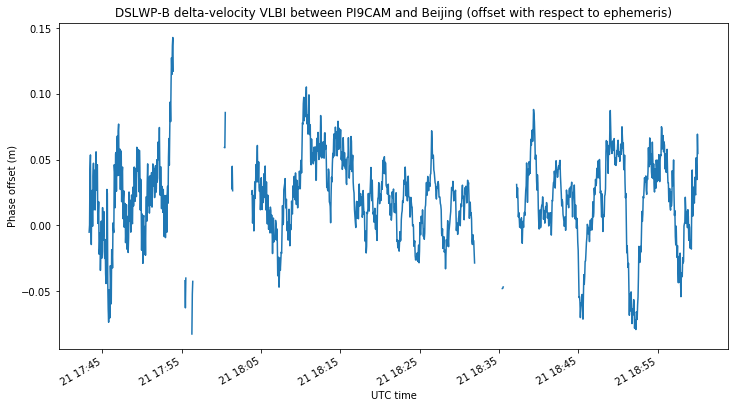

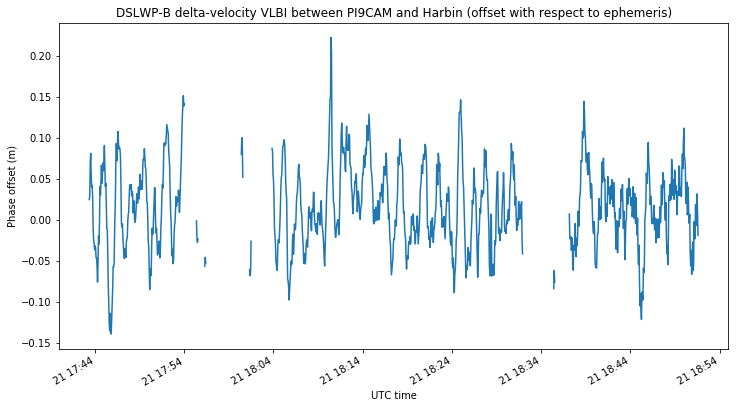

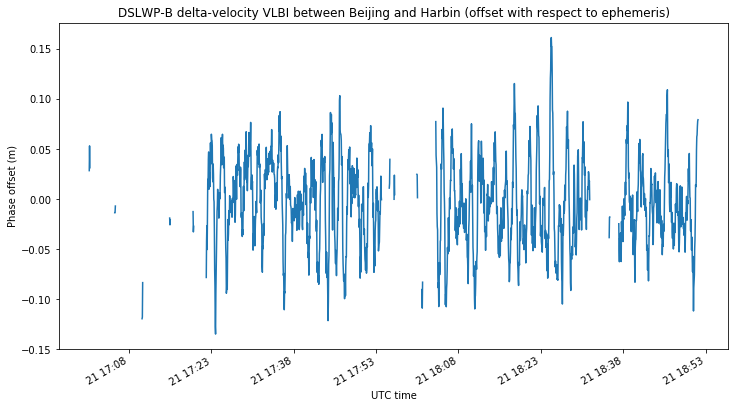

In [18]:
plot_doppler_error(pi9cam_shahe, 'PI9CAM', 'Beijing')
plot_doppler_error(pi9cam_harbin, 'PI9CAM', 'Harbin')
plot_doppler_error(shahe_harbin, 'Beijing', 'Harbin')